# In this notebook, the ARIMA and SARIMA models will be explored

The methodology followed for producing an ARIMA model is summarized in the following flowchart, taken from Hyndmann.

![Hyndmann Modeling Porcess](hyndman-modeling-process.png)

In [3]:
%matplotlib inline

import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf
keras = tf.keras
from sklearn.model_selection import train_test_split

# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

import pickle
from datetime import datetime

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passi

In [4]:
# get the data
df_CHN_CTC_leaf = pd.read_csv('../Data/df_CHN_CTC_leaf.csv')
# print(df_CHN_CTC_leaf.tail(40))
# grab 2020 data separately
df_CHN_CTC_leaf_2020 = df_CHN_CTC_leaf[pd.to_datetime(df_CHN_CTC_leaf['week_ending']) > pd.to_datetime('2020-01-01')]
df_CHN_CTC_leaf = df_CHN_CTC_leaf[pd.to_datetime(df_CHN_CTC_leaf['week_ending']) < pd.to_datetime('2020-01-01')]

price_series = df_CHN_CTC_leaf['ctc_leaf_avg_price']
time_series = pd.to_datetime(df_CHN_CTC_leaf['week_ending'])
price_series.index = time_series

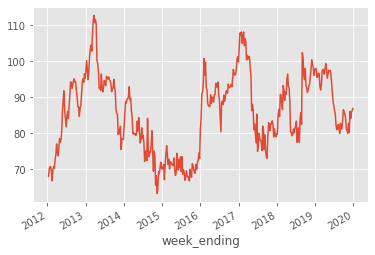

In [5]:
price_series.plot();

In [6]:
def plot_series_and_difference(axs, price_series, time_series, title):
    diff = price_series.diff()
    axs[0].plot(time_series, price_series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(time_series, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))

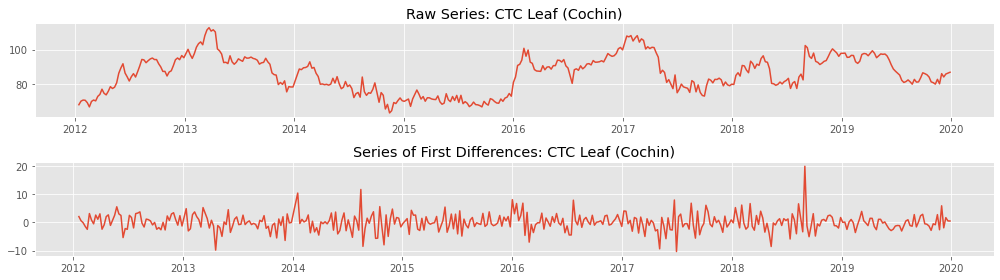

In [7]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, price_series, time_series, 'CTC Leaf (Cochin)')
fig.tight_layout()

In [8]:
# Check for stationarity
price_differences = price_series.diff()[1:]
ADF_p_value = sm.tsa.stattools.adfuller(price_differences)
print("ADF p-value for differenced price series: {0:2.2f}".format(ADF_p_value[1]))

ADF p-value for differenced price series: 0.00


So the differenced series is stationary, and we can attempt to model it as an ARMA process.

We need to determine the correct order for the AR and MA models, so let's look at the auto and partial auto correlation plots.

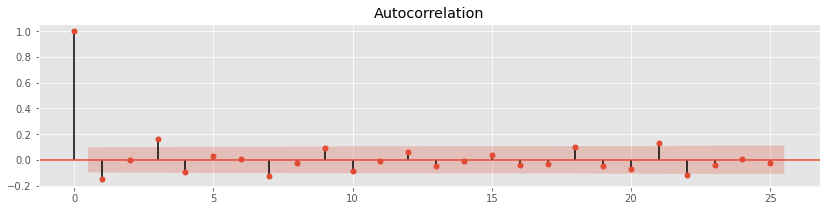

In [9]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(price_differences, lags=25, ax=ax)

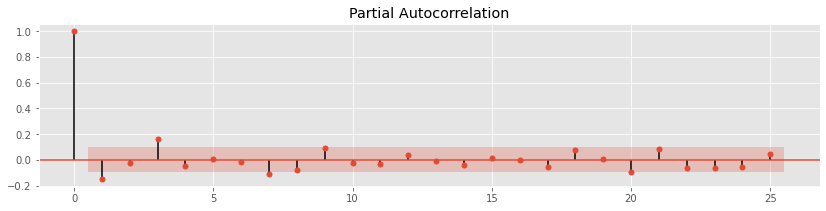

In [10]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_pacf(price_differences, lags=25, ax=ax)

We see the following evidence:
  - Oscillatory behavior in the autocorrelation plot. One significant data point at the beginning of the plot. So ?????
  - One significant partial autocorrelations at the beginning of the plot.
  
This suggests that the differenced series may be well modeled as an $AR(1)$ series.

Since we applied *one* difference to achieve stationarity, this suggests that we should model the *original* series as an $ARIMA(1, 1, !)$.

In [11]:
# # try 2nd rder differencing
# # Check for stationarity
# price_second_differences = price_differences.diff()[1:]
# ADF_p_value = sm.tsa.stattools.adfuller(price_second_differences)
# print("ADF p-value for differenced price series: {0:2.2f}".format(ADF_p_value[1]))

In [12]:
# fig, ax = plt.subplots(1, figsize=(14, 3))
# _ = sm.graphics.tsa.plot_acf(price_second_differences, lags=25, ax=ax)
# fig, ax = plt.subplots(1, figsize=(14, 3))
# _ = sm.graphics.tsa.plot_pacf(price_second_differences, lags=25, ax=ax)

## Fit the ARIMA model

In [13]:
price_model = ARIMA(price_series, order=(1, 1, 1)).fit()

In [14]:
def format_list_of_floats(L):
    return ["{0:2.2f}".format(f) for f in L]

In [15]:
print("ARIMA(1, 1, 0) coefficients from Price model:\n  Intercept {0:2.2f}\n  AR {1}".format(
    price_model.params[0], 
        format_list_of_floats(list(price_model.params[1:]))
    ))

ARIMA(1, 1, 0) coefficients from Price model:
  Intercept 0.05
  AR ['-0.10', '-0.05']


Let's simulate some data using these coefficients and see if it looks like our differenced data.

In [16]:
def auto_regressive_process(size, coefs, init=None):
    """Generate an autoregressive process with Gaussian white noise.  The
    implementation is taken from here:
    
      http://numpy-discussion.10968.n7.nabble.com/simulate-AR-td8236.html
      
    Exaclty how lfilter works here takes some pen and paper effort.
    """
    coefs = np.asarray(coefs)
    if init == None:
        init = np.array([0]*len(coefs))
    else:
        init = np.asarray(init)
    init = np.append(init, np.random.normal(size=(size - len(init))))
    assert(len(init) == size)
    a = np.append(np.array([1]), -coefs)
    b = np.array([1])
    return pd.Series(signal.lfilter(b, a, init))

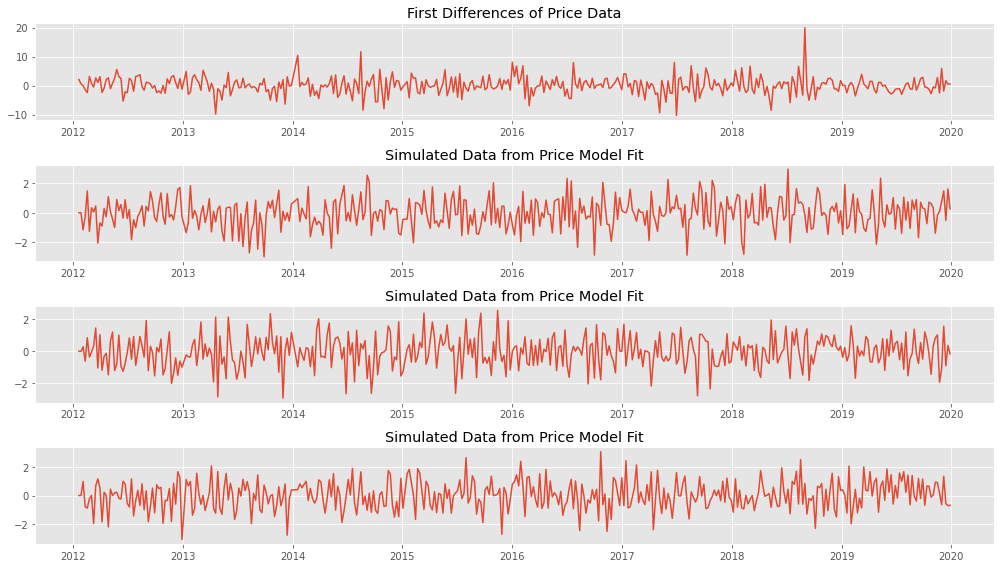

In [17]:
fig, ax = plt.subplots(4, figsize=(14, 8))

ax[0].plot(time_series[1:], price_differences)
ax[0].set_title("First Differences of Price Data")

for i in range(1, 4):
    simulated_data = auto_regressive_process(len(price_differences), 
                                             list(price_model.params)[1:])
    simulated_data.index = time_series[1:]
    ax[i].plot(simulated_data.index, simulated_data)
    ax[i].set_title("Simulated Data from Price Model Fit")
    
plt.tight_layout()

We have done a bit better than the naive forecast of predicting the last observed value.

We can also use the fit model to project prices into the future.

In [18]:
price_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARIMA Model Results                               
================================================================================
Dep. Variable:     D.ctc_leaf_avg_price   No. Observations:                  411
Model:                   ARIMA(1, 1, 1)   Log Likelihood               -1041.313
Method:                         css-mle   S.D. of innovations              3.048
Date:                  Sat, 19 Sep 2020   AIC                           2090.626
Time:                          17:35:47   BIC                           2106.700
Sample:                               1   HQIC                          2096.985
                                                                                
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0450      0.130      0.348      0.728      -0.209       0.299
ar.L1.D.ctc_leaf_avg_price    -0.1045      0.189     -0.554      0.580      -0.474       0.265
ma.L1.D.ctc_leaf_avg_price    -0.0489      0.185     -0.264      0.792      -0.412       0.314
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -9.5732           +0.0000j            9.5732            0.5000
MA.1           20.4700           +0.0000j           20.4700            0.0000
-----------------------------------------------------------------------------
"""

In [19]:
price_series[-100:]

week_ending
2018-02-03    90.83
2018-02-10    90.56
2018-02-17    88.16
2018-02-24    86.60
2018-03-03    93.30
              ...  
2019-11-30    86.08
2019-12-07    84.15
2019-12-14    85.86
2019-12-21    86.39
2019-12-28    86.89
Name: ctc_leaf_avg_price, Length: 100, dtype: float64

week_ending
2018-02-03    0.336249
2018-02-10    0.014608
2018-02-17    0.048206
2018-02-24    0.044696
2018-03-03    0.045063
                ...   
2019-11-30    0.045028
2019-12-07    0.045028
2019-12-14    0.045028
2019-12-21    0.045028
2019-12-28    0.045028
Length: 100, dtype: float64


Text(0.5, 1.0, 'Forecasts for Price')

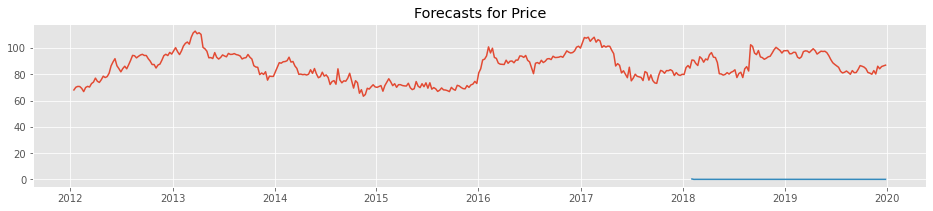

In [20]:
fig, ax = plt.subplots(1, figsize=(16, 3))
ax.plot(price_series.index, price_series)

# predictions = price_model.predict(
#    price_series.index.max(), pd.to_datetime('2020-09-12'), 
#    dynamic=True)

price_model = ARIMA(price_series, order=(1, 1, 1)).fit()

predictions = price_model.predict('2018-02-03', '2019-12-28', dynamic=True)
print(predictions)
ax.plot(predictions.index, predictions)
ax.set_title("Forecasts for Price")

If our model is good, the residuals should have no patterns whatsoever, i.e. be *white noise*

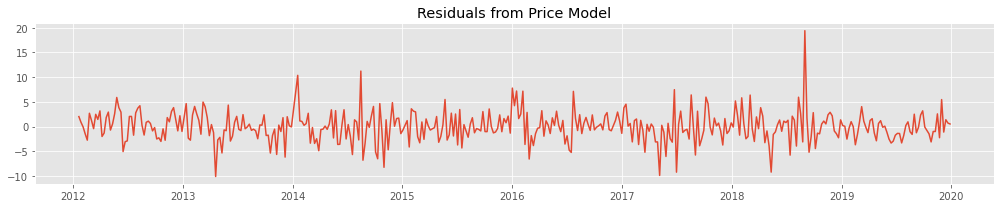

In [21]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(price_model.resid.index, price_model.resid)
ax.set_title("Residuals from Price Model")
plt.tight_layout()

One way to diagnose this is to check if any autocorrelation remains in the residuals.

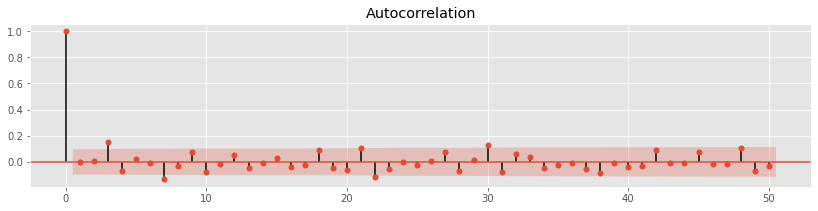

In [22]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(price_model.resid, lags=50, ax=ax)

### Model Selection: AIC

In [23]:
parameters = [
    {'AR': 2, 'MA': 0},
    {'AR': 2, 'MA': 1},
    {'AR': 1, 'MA': 0},
    {'AR': 1, 'MA': 1},
    {'AR': 3, 'MA': 0},
    {'AR': 3, 'MA': 1}
]

models = {}
for params in parameters:
    models[(params['AR'], params['MA'])] = ARIMA(price_series, order=(params['AR'], 1, params['MA'])).fit()
    
for model_params in models:
    print("ARIMA({}, 1, {}) AIC: {}".format(model_params[0], model_params[1], models[model_params].aic))

ARIMA(2, 1, 0) AIC: 2090.4780128400175
ARIMA(2, 1, 1) AIC: 2086.769481885754
ARIMA(1, 1, 0) AIC: 2088.6958921646
ARIMA(1, 1, 1) AIC: 2090.6257909046717
ARIMA(3, 1, 0) AIC: 2081.4707156798518
ARIMA(3, 1, 1) AIC: 2082.3967226022896


In [24]:
# Calculating MAPE (Mean Absolute Precentage Error)
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

## Poor results! Try Auto ARIMA

In [25]:
! pip install pmdarima

In [26]:
from pmdarima.arima import auto_arima

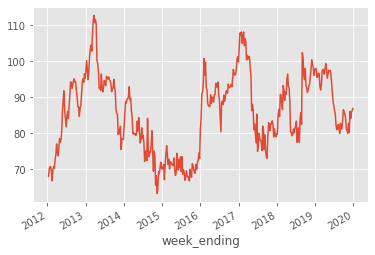

In [27]:
price_series.plot();

In [28]:
from pmdarima.arima import ADFTest

In [29]:
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(price_series)

(0.23022144267525393, True)

#### Data is non-stationary

In [30]:
# Train test split. Use some data to train, then test against remaing data to evaluate the model.

price_series_train = price_series[:350]
price_series_test = price_series[350:] 

In [31]:
print(f'train on {len(price_series_train)} data points')
print(f'test on {len(price_series_test)} data points')

train on 350 data points
test on 62 data points


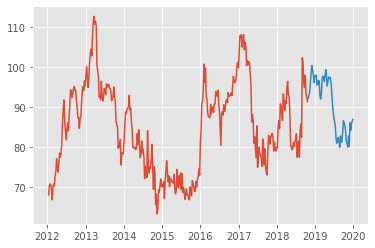

In [32]:
plt.plot(price_series_train)
plt.plot(price_series_test)

In [33]:
# price_model = auto_arima(price_series_train, start_p=0, d=1, start_q=0, 
#                          max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0,
#                          max_Q=5, m=52, seasonal=True,
#                          error_action='warn', trace=True,
#                          suppress_warnings=True, stepwise=True,
#                          random_state=13, n_fits=50)

# Performing stepwise search to minimize aic
#  ARIMA(0,1,0)(0,1,0)[52]             : AIC=1763.291, Time=0.32 sec
#  ARIMA(1,1,0)(1,1,0)[52]             : AIC=1652.838, Time=3.10 sec
#  ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=22.98 sec
#  ARIMA(1,1,0)(0,1,0)[52]             : AIC=1746.207, Time=0.43 sec
#  ARIMA(1,1,0)(2,1,0)[52]             : AIC=1634.262, Time=10.84 sec
#  ARIMA(1,1,0)(2,1,1)[52]             : AIC=inf, Time=43.72 sec
#  ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=12.09 sec
#  ARIMA(0,1,0)(2,1,0)[52]             : AIC=inf, Time=7.80 sec
#  ARIMA(2,1,0)(2,1,0)[52]             : AIC=1635.287, Time=16.89 sec
#  ARIMA(1,1,1)(2,1,0)[52]             : AIC=1635.888, Time=16.04 sec
#  ARIMA(0,1,1)(2,1,0)[52]             : AIC=1633.951, Time=13.58 sec
#  ARIMA(0,1,1)(1,1,0)[52]             : AIC=1652.380, Time=3.72 sec
#  ARIMA(0,1,1)(2,1,1)[52]             : AIC=inf, Time=46.78 sec
#  ARIMA(0,1,1)(1,1,1)[52]             : AIC=inf, Time=14.55 sec
#  ARIMA(0,1,2)(2,1,0)[52]             : AIC=1635.763, Time=14.70 sec
#  ARIMA(1,1,2)(2,1,0)[52]             : AIC=1634.636, Time=29.73 sec
#  ARIMA(0,1,1)(2,1,0)[52] intercept   : AIC=1635.904, Time=26.02 sec

# Best model:  ARIMA(0,1,1)(2,1,0)[52]          
# Total fit time: 283.390 seconds

In [34]:
price_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARIMA Model Results                               
================================================================================
Dep. Variable:     D.ctc_leaf_avg_price   No. Observations:                  411
Model:                   ARIMA(1, 1, 1)   Log Likelihood               -1041.313
Method:                         css-mle   S.D. of innovations              3.048
Date:                  Sat, 19 Sep 2020   AIC                           2090.626
Time:                          17:36:03   BIC                           2106.700
Sample:                               1   HQIC                          2096.985
                                                                                
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0450      0.130      0.348      0.728      -0.209       0.299
ar.L1.D.ctc_leaf_avg_price    -0.1045      0.189     -0.554      0.580      -0.474       0.265
ma.L1.D.ctc_leaf_avg_price    -0.0489      0.185     -0.264      0.792      -0.412       0.314
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -9.5732           +0.0000j            9.5732            0.5000
MA.1           20.4700           +0.0000j           20.4700            0.0000
-----------------------------------------------------------------------------
"""

### SARIMAX (0,1,1)(2,1,0)[52] with a seasonality of 52 weeks AIC = 1633.951

In [35]:
# retrain the best model on all data upto end 2019
SARIMAX_price_model = auto_arima(price_series_train, start_p=0, d=1, start_q=1, 
                                 max_p=0, max_d=1, max_q=1, start_P=2, D=1, start_Q=0,
                                 max_Q=0, m=52, seasonal=True,
                                 error_action='warn', trace=True,
                                 suppress_warnings=True, stepwise=True,
                                 random_state=13, n_fits=50)
SARIMAX_price_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(2,1,0)[52]             : AIC=1633.951, Time=5.74 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1763.291, Time=0.28 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=1664.316, Time=0.96 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1745.404, Time=0.27 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1652.380, Time=1.62 sec
 ARIMA(0,1,0)(2,1,0)[52]             : AIC=inf, Time=3.33 sec
 ARIMA(0,1,1)(2,1,0)[52] intercept   : AIC=1635.904, Time=9.61 sec

Best model:  ARIMA(0,1,1)(2,1,0)[52]          
Total fit time: 21.831 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  350
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 52)   Log Likelihood                -812.976
Date:                             Sat, 19 Sep 2020   AIC                           1633.951
Time:                                     17:36:26   BIC                           1648.726
Sample:                                          0   HQIC                          1639.866
                                             - 350                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1770      0.063     -2.809      0.005      -0.301      -0.054
ar.S.L52      -0.7579      0.063    -11.990      0.000      -0.882      -0.634
ar.S.L104     -0.3316      0.076     -4.381      0.000      -0.480      -0.183
sigma2        12.5194      0.777     16.106      0.000      10.996      14.043
===================================================================================
Ljung-Box (Q):                       79.32   Jarque-Bera (JB):               139.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                             0.59
Prob(H) (two-sided):                  0.18   Kurtosis:                         6.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
predictions = pd.DataFrame(SARIMAX_price_model.predict(n_periods=62),index=price_series_test.index)
predictions.columns = ['predicted_price']
predictions

predicted_price
week_ending                 
2018-10-27         90.639684
2018-11-03         91.833982
2018-11-10         92.845181
2018-11-17         93.445773
2018-11-24         92.489161
...                      ...
2019-11-30         96.358038
2019-12-07         98.042166
2019-12-14         98.631787
2019-12-21         98.560508
2019-12-28         99.028732

[62 rows x 1 columns]

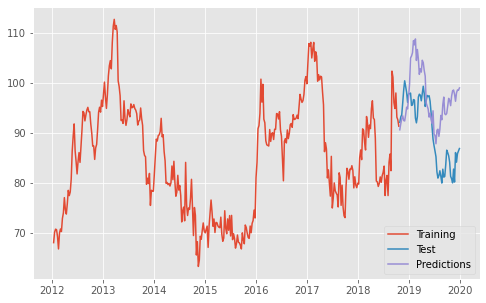

In [37]:
plt.figure(figsize=(8,5))
plt.plot(price_series_train, label='Training')
plt.plot(price_series_test, label='Test')
plt.plot(predictions, label='Predictions')
plt.legend(loc='Left corner')
plt.show()

In [38]:
# Calculating MAPE (Mean Absolute Precentage Error), as advised by Dr. Agrawal
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [39]:
print(f'MAPE = {mape(price_series_test, predictions)}')

MAPE = 9.996468813897012


### MAPE = 9.996468813897012 (over 2020 predictions is not bad given COVID disruptions)

### The model is doing much better


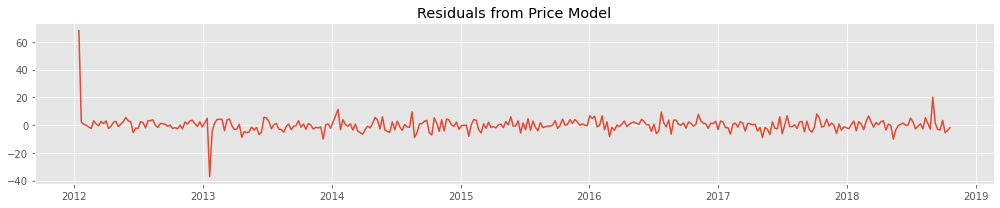

In [40]:
# Let's check the residuals to see if their variability looks like white noise

fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(price_series_train.index, SARIMAX_price_model.resid())
ax.set_title("Residuals from Price Model")
plt.tight_layout()

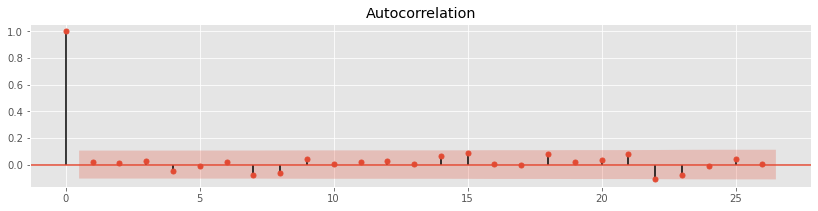

In [41]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(SARIMAX_price_model.resid(), ax=ax)

### Looks good! There are no significant autocorrelations.

### Now that we found accetable results from the test data
##### Best model:  ARIMA(0,1,1)(2,1,0)[52] with test data (AIC = 1633.951)

### Now let's try with a seasonalty of 104 weeks because seasonality from year to year is not apparent)

In [42]:
# # Let's try with different seasonality m=104
# SARIMAX_104_price_model = auto_arima(price_series, start_p=0, d=1, start_q=0, 
#                               max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0,
#                               max_Q=5, m=104, seasonal=True,
#                               error_action='warn', trace=True,
#                               suppress_warnings=True, stepwise=True,
#                               random_state=13, n_fits=50)
# SARIMAX_104_price_model.summary()


#### Seasonality of 104 weeks gave model SARIMAX (2,1,2)(2,1,0)[104](AIC = 1662.785) which is worse than seasonality of 52


### Now let's try with a seasonalty of 156 weeks - tea plant maturity)

In [43]:
SARIMAX_156_price_model = auto_arima(price_series_train, start_p=0, d=1, start_q=0, 
                         max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0,
                         max_Q=5, m=156, seasonal=True,
                         error_action='warn', trace=True,
                         suppress_warnings=True, stepwise=True,
                         random_state=13, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[156]             : AIC=1116.062, Time=2.22 sec
 ARIMA(1,1,0)(1,1,0)[156]             : AIC=inf, Time=22.69 sec
 ARIMA(0,1,1)(0,1,1)[156]             : AIC=inf, Time=26.96 sec
 ARIMA(0,1,0)(1,1,0)[156]             : AIC=inf, Time=15.79 sec
 ARIMA(0,1,0)(0,1,1)[156]             : AIC=inf, Time=20.31 sec
 ARIMA(0,1,0)(1,1,1)[156]             : AIC=1117.473, Time=24.05 sec
 ARIMA(1,1,0)(0,1,0)[156]             : AIC=1114.928, Time=2.57 sec
 ARIMA(1,1,0)(0,1,1)[156]             : AIC=inf, Time=20.80 sec
 ARIMA(1,1,0)(1,1,1)[156]             : AIC=1116.001, Time=31.36 sec
 ARIMA(2,1,0)(0,1,0)[156]             : AIC=1116.778, Time=3.23 sec
 ARIMA(1,1,1)(0,1,0)[156]             : AIC=1116.869, Time=5.15 sec
 ARIMA(0,1,1)(0,1,0)[156]             : AIC=1114.882, Time=3.36 sec
 ARIMA(0,1,1)(1,1,0)[156]             : AIC=1113.899, Time=24.58 sec
 ARIMA(0,1,1)(2,1,0)[156]             : AIC=1115.899, Time=96.29 sec
 ARIMA(0,1,1)(1,1,1)[

### And again check the residuals to see if their variability looks like white noise

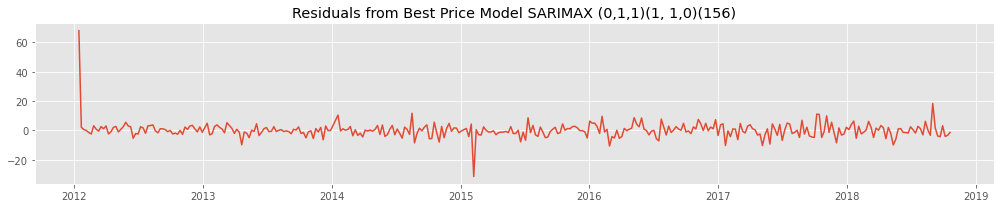

In [48]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(price_series_train.index, SARIMAX_156_price_model.resid())
ax.set_title("Residuals from Best Price Model SARIMAX (0,1,1)(1, 1,0)(156)")
plt.tight_layout()

### and check for correlations

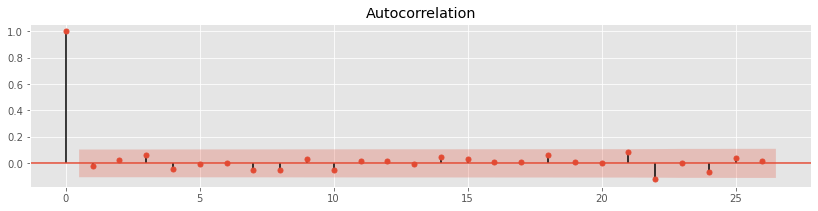

In [49]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(SARIMAX_156_price_model.resid(), ax=ax)

#### SARIMAX(0,1,1)(2,1,0)[52] with test data (AIC = 1633.951)
#### SARIMAX(2,1,2)(2,1,0)[104] with test data (AIC = 1662.785)
### SARIMAX(0,1,1)(1,1,0)[156] with test data (AIC=1113.899) ... is the best!

In [54]:
# retrain the best model on all data upto end 2019
SARIMAX_156_price_model = auto_arima(price_series_train, start_p=0, d=1, start_q=1, 
                                 max_p=0, max_d=1, max_q=1, start_P=1, D=1, start_Q=0,
                                 max_Q=0, m=156, seasonal=True,
                                 error_action='warn', trace=True,
                                 suppress_warnings=True, stepwise=True,
                                 random_state=13, n_fits=50)


Performing stepwise search to minimize aic
 ARIMA(0,1,1)(1,1,0)[156]             : AIC=1113.899, Time=22.64 sec
 ARIMA(0,1,0)(0,1,0)[156]             : AIC=1116.062, Time=2.25 sec
 ARIMA(0,1,0)(1,1,0)[156]             : AIC=inf, Time=14.47 sec
 ARIMA(0,1,1)(0,1,0)[156]             : AIC=1114.882, Time=3.43 sec
 ARIMA(0,1,1)(2,1,0)[156]             : AIC=1115.899, Time=97.96 sec
 ARIMA(0,1,1)(1,1,0)[156] intercept   : AIC=1115.896, Time=34.00 sec

Best model:  ARIMA(0,1,1)(1,1,0)[156]          
Total fit time: 174.932 seconds


In [55]:
SARIMAX_156_price_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  350
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 156)   Log Likelihood                -553.949
Date:                              Sat, 19 Sep 2020   AIC                           1113.899
Time:                                      18:18:02   BIC                           1123.687
Sample:                                           0   HQIC                          1117.863
                                              - 350                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1354      0.071     -1.908      0.056      -0.275       0.004
ar.S.L156     -0.3126      0.241     -1.298      0.194      -0.785       0.159
sigma2        16.7653      2.545      6.588      0.000      11.778      21.753
===================================================================================
Ljung-Box (Q):                       59.72   Jarque-Bera (JB):                33.19
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.94   Skew:                             0.47
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predict last weeks of 2019

In [67]:
price_series.index[409]

Timestamp('2019-12-14 00:00:00')

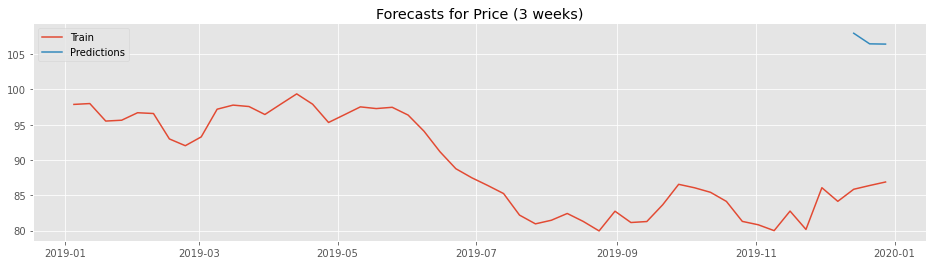

In [93]:
fig, ax = plt.subplots(1, figsize=(16, 4))

ax.plot(price_series.index[-52:], price_series[-52:], label='Train')

results = SARIMAX_156_price_model.arima_res_
predictions = results.predict(409, 411, plot_insample=False)
# results = SARIMAX_156_price_model.arima_res_ .get_prediction('2019-12-14', '2019-12-28', 
#                    dynamic=True, ax=ax, plot_insample=False)
# predictions = results.predicted_mean
ci = results.conf_int()

predictions
type(ci)

ax.plot(price_series.index[-3:], predictions, label='Predictions');
# ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='k', alpha=0.1)
ax.legend(loc='best')
ax.set_title("Forecasts for Price (3 weeks)");

In [94]:
len(predictions)

3

In [95]:
#print(f'MAPE for 8 weeks prediction = {mape(price_series[-8:], predictions)}') 5.283649980995582
#print(f'MAPE for 4 weeks prediction = {mape(price_series[-4:], predictions)}') 1.8025087689068624
print(f'MAPE for 3 weeks prediction = {mape(price_series[-3:], predictions)}') #1.406900113236694
#print(f'MAPE for 2 weeks prediction = {mape(price_series[-2:], predictions)}') 2.1213764454657573
#print(f'MAPE for 1 week prediction = {mape(price_series[-1:], predictions)}')  2.871966068801266

MAPE for 3 weeks prediction = 23.81582456374831


### Results for various SARIMAX models
#### SARIMAX(0,1,1)(2,1,0)[52] with test data       best AIC > 2000 
        MAPE for 42 weeks prediction = 9.996468813897012
#### SARIMAX(0,1,1)(2,1,0)[52] with all data         best AIC > 1800
#### SARIMAX(2,1,2)(2,1,0)[104] w/ all data.         best AIC = 1662.785 
        MAPE for 8 weeks prediction = 5.283649980995582
        MAPE for 4 weeks prediction = 1.8025087689068624
    ____MAPE for 3 weeks prediction = 1.406900113236694____
        MAPE for 2 weeks prediction = 2.1213764454657573
        MAPE for 1 week prediction  = 2.871966068801266
#### SARIMAX(1,1,0)(0,1,0)[156] w/ all data.         best AIC = 1446.217
        MAPE for 3 weeks prediction = 6.438030862125399

### Let's get some predictions for 2020 (pre-COVID)

In [ ]:
# # Pandas is a bit fussy about reindexing here, we need to extend the dates but
# # Pandas's weekly series does not align with google's.
# price_series.index = pd.date_range(start='2020-01-, end='9-25-2016', freq='W')
# price_series = price_series.reindex(pd.date_range(start='10-7-2011', end='2020', freq='W'))

### Predict 3 weeks in Jan 2020

In [ ]:
# Actuals for 2020 (pre-COVID end february)
price_series_2020_pc = df_CHN_CTC_leaf_2020['ctc_leaf_avg_price'].iloc[:3]
price_series_2020_pc.index = pd.date_range(start='2020-01-04', end='2020-01-18', freq='W-SAT')
price_series_2020_pc

In [ ]:
#fig, ax = plt.subplots(1, figsize=(16, 4))

predictions_index = pd.date_range(start='2019-12-28', end='2020-01-12', freq='W-SAT')
predictions = SARIMAX_price_model.forecast(steps=3)
predictions.index = predictions_index
predictions

plt.plot(price_series.index[-52:], price_series[-52:], label='Train', c='r')
plt.plot(price_series_2020_pc.index[:3], price_series_2020_pc[:3], label='Known 2020', c='g')
plt.plot(predictions.index, predictions, label='Predictions', c='b')

plt.title("Forecasts for Price")
plt.legend(loc='best')
plt.show();

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(price_series, label='Training')
plt.plot(price_series_2020_pc, label='Test')
plt.plot(predictions, label='Predictions')
plt.legend(loc='Left corner')
plt.show()

In [ ]:
print(f'MAPE for 3 weeks prediction = {mape(price_series_2020_pc[:3], predictions[:3])}')

### Now let's try statsmodels.tsa.holtwinters.ExponentialSmoothing

In [ ]:
# from statsmodels.tsa.holtwinters import ExponentialSmoothing as Holt

# HWES_price_model = Holt(np.asarray(price_series), seasonal_periods=52)
# HWES_price_model._index = pd.to_datetime(price_series.index)

# fit1 = HWES_price_model.fit(smoothing_level=.3, smoothing_slope=.05)
# #pred1 = fit1.forecast(steps=3)
# # fit2 = HWES_price_model.fit(optimized=True)
# # pred2 = fit2.forecast(9)
# # fit3 = HWES_price_model.fit(smoothing_level=.3, smoothing_slope=.2)
# # pred3 = fit3.forecast(3)

# # fig, ax = plt.subplots(figsize=(12, 6))
# # ax.plot(price_series.index[52:], price_series.values[52:])
# # ax.plot(test.index, test.values, color="gray")
# # for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
# #     ax.plot(train.index[150:], f.fittedvalues[150:], color=c)
# #     ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4], color=c)
# # plt.title("Holt's Exponential Smoothing")
# # plt.legend();

## LSTM

#### Reload the data

The plan:

First run only price data to do a univariate LSTM ... DONE
Check results for all data including 2020 ... Poor Results

Check results for 2019 data only ... DONE, good results
Compare predictions with known 2020 data ... DONE dood results

Then do multivariate with price, offer qty and sold qty, for 1 tea category
Then add all categories

In [388]:
# load dataset
df_CHN_CTC_leaf = pd.read_csv('../Data/df_CHN_CTC_leaf.csv', header=0, index_col=0)
df_CHN_CTC_dust = pd.read_csv('../Data/df_CHN_CTC_dust.csv', header=0, index_col=0)
df_CHN_Ortho_leaf = pd.read_csv('../Data/df_CHN_Ortho_leaf.csv', header=0, index_col=0)
df_CHN_Ortho_dust = pd.read_csv('../Data/df_CHN_Ortho_dust.csv', header=0, index_col=0)

In [389]:
# # chop out 2020 data
# df_CHN_CTC_leaf = df_CHN_CTC_leaf[pd.to_datetime(df_CHN_CTC_leaf.index) < pd.to_datetime('2020-01-01')]
# df_CHN_CTC_dust = df_CHN_CTC_dust[pd.to_datetime(df_CHN_CTC_dust.index) < pd.to_datetime('2020-01-01')]
# df_CHN_Ortho_leaf = df_CHN_Ortho_leaf[pd.to_datetime(df_CHN_Ortho_leaf.index) < pd.to_datetime('2020-01-01')]
# df_CHN_Ortho_dust = df_CHN_Ortho_dust[pd.to_datetime(df_CHN_Ortho_dust.index) < pd.to_datetime('2020-01-01')]

In [390]:
def plot_oqty_sqty_avgp(df, category, city):

    fig, axs = plt.subplots(3, figsize=(15, 10))

    axs[0].plot(pd.to_datetime(df.index), df[category + '_offer_qty'],'*-', c='r',
                label=category.upper() + ' Offer Qty')
    axs[0].set_title(category.upper() + ' Offer Qty - ' + city)
    axs[0].set_ylabel('Kgs')
    axs[0].legend(loc='best')
    axs[0].tick_params(rotation=75, axis='x')
                            
    axs[1].plot(pd.to_datetime(df.index), df[category + '_sold_qty'], '*-', c='g',
                label=category.upper() + ' Sold Qty')
    axs[1].set_title(category.upper() + ' Sold Qty - ' + city)
    axs[1].set_ylabel('Kgs')
    axs[1].legend(loc='best')
    axs[1].tick_params(rotation=75, axis='x')
                            
    axs[2].plot(pd.to_datetime(df.index), df[category + '_avg_price'],'*-', c='b',
                label=category.upper() + ' Avg Price')
    axs[2].set_title(category.upper() + ' Avg Price - ' + city)
    axs[2].set_ylabel('Kgs')
    axs[2].legend(loc='best')
    axs[2].tick_params(rotation=75, axis='x')


    fig.tight_layout()
    fig.savefig('../Images/' + category.upper() + '_' + city + '_oqty_sqty_avgp' + get_timestamp())
                        
                        
# values = dataset.values
# # specify columns to plot
# groups = [0, 1, 2, 3, 5, 6, 7]
# i = 1
# # plot each column
# pyplot.figure()
# for group in groups:
# 	pyplot.subplot(len(groups), 1, i)
# 	pyplot.plot(values[:, group])
# 	pyplot.title(dataset.columns[group], y=0.5, loc='right')
# 	i += 1
# pyplot.show()

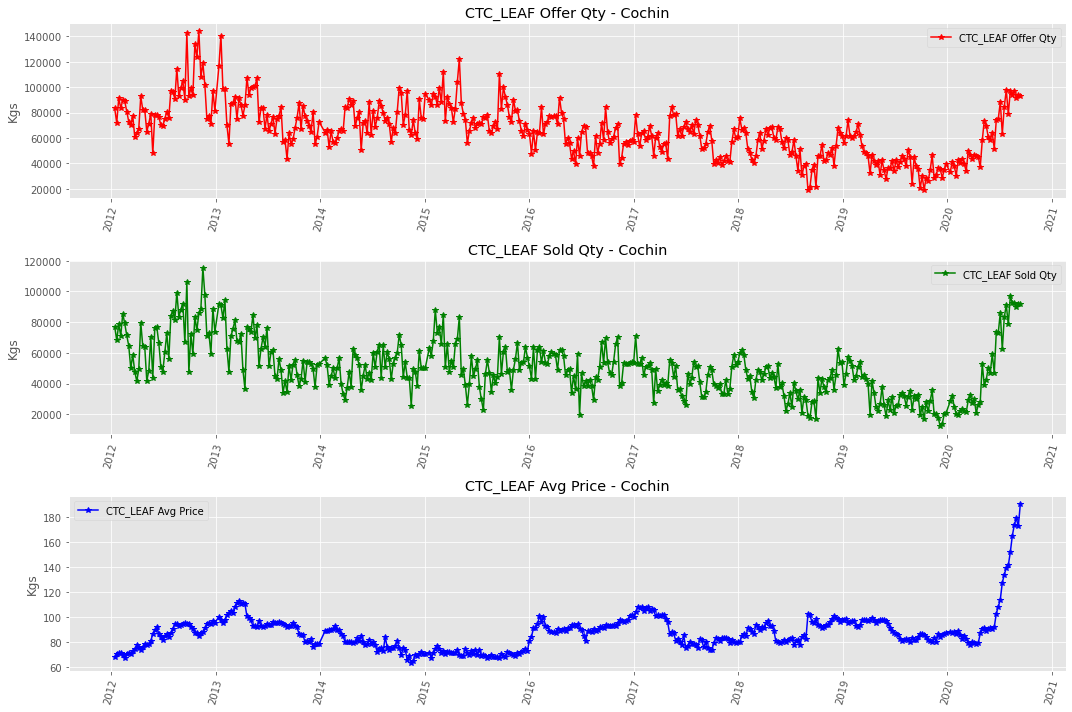

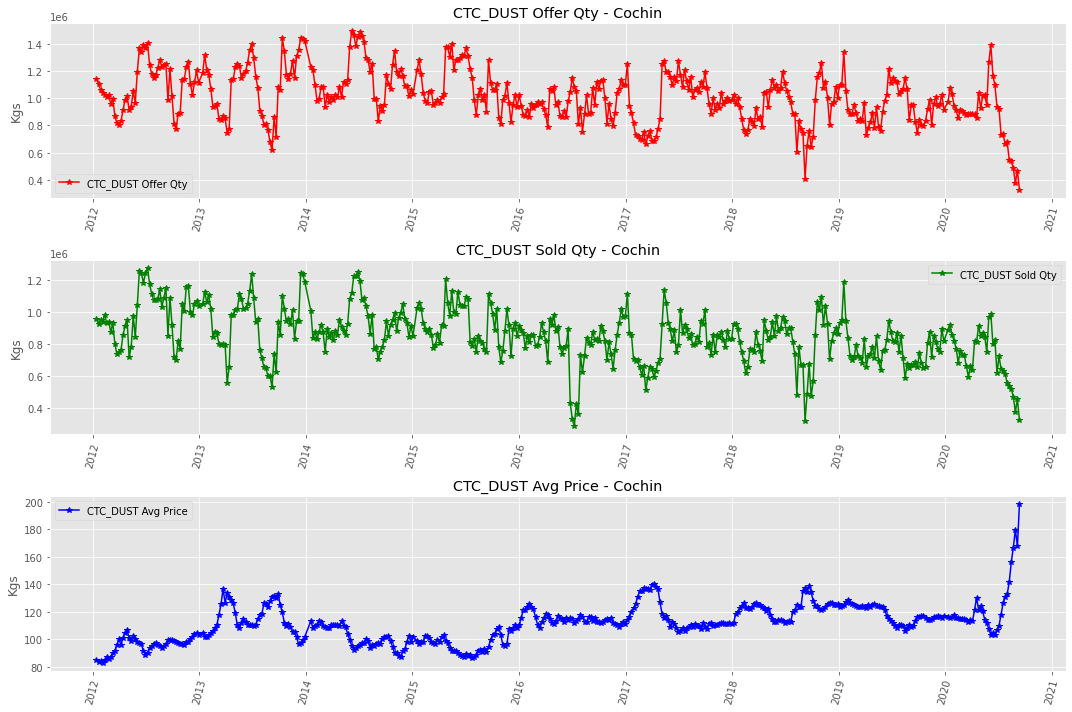

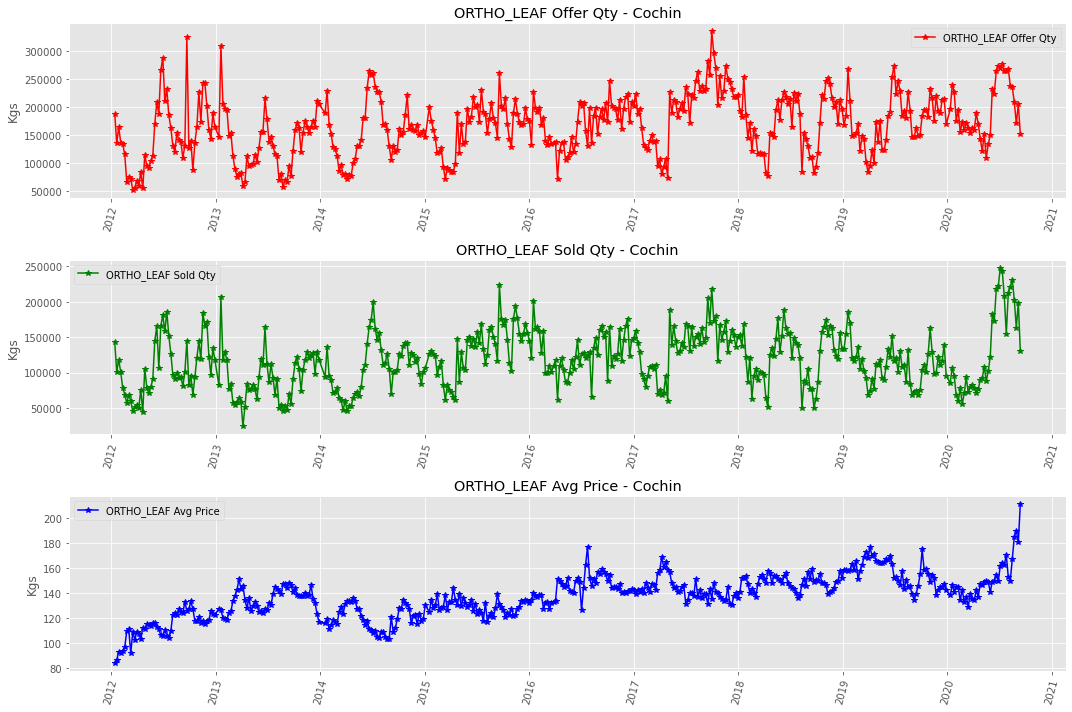

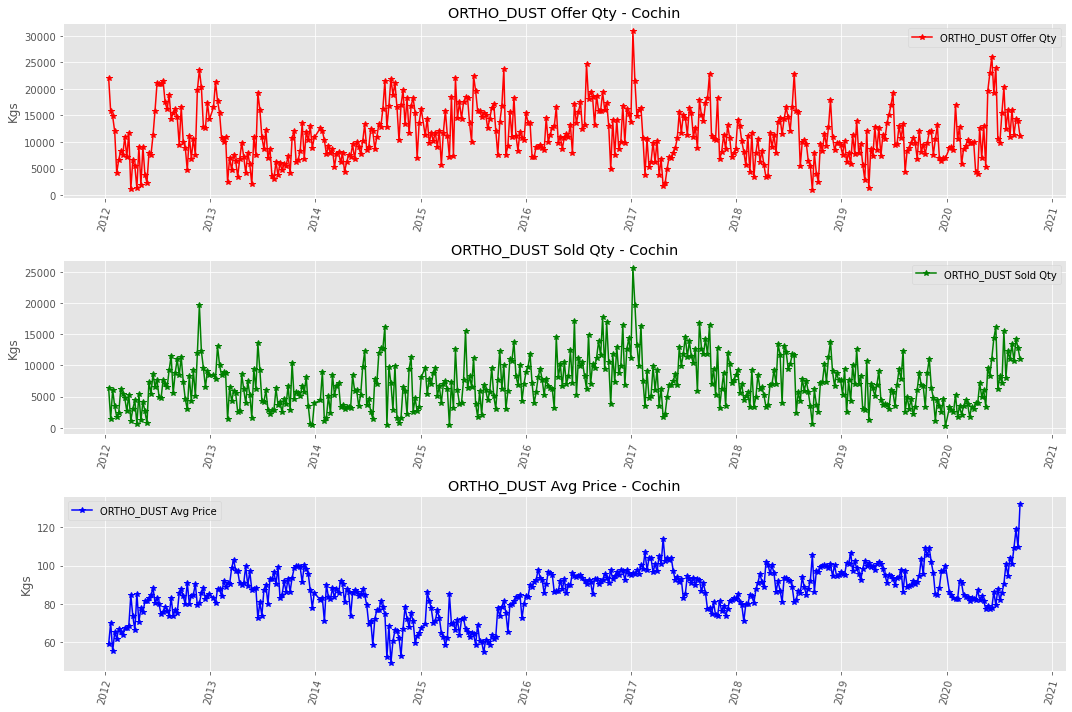

In [391]:
plot_oqty_sqty_avgp(df_CHN_CTC_leaf, 'ctc_leaf', 'Cochin')
plot_oqty_sqty_avgp(df_CHN_CTC_dust, 'ctc_dust', 'Cochin')
plot_oqty_sqty_avgp(df_CHN_Ortho_leaf, 'ortho_leaf', 'Cochin')
plot_oqty_sqty_avgp(df_CHN_Ortho_dust, 'ortho_dust', 'Cochin')

## Univariate

First we need to get the data into a format we can put into an RNN. Each training data point should consist of a sequence of consecutive values for our data (for input) and the next value of our data (for output).

First we'll write a function to consider every possible group of 52 values followed by one value (for the output) along our time-series data.

In [392]:
# Set up the first price series
price_series = df_CHN_CTC_leaf['ctc_leaf_avg_price']
time_series = price_series.index #pd.to_datetime(df_CHN_CTC_leaf['week_ending'])
# price_series.index = time_series
time_series

Index(['14-Jan-12', '21-Jan-12', '28-Jan-12', '4-Feb-12', '11-Feb-12',
       '18-Feb-12', '25-Feb-12', '3-Mar-12', '10-Mar-12', '17-Mar-12',
       ...
       '11-Jul-20', '18-Jul-20', '25-Jul-20', '1-Aug-20', '8-Aug-20',
       '15-Aug-20', '22-Aug-20', '29-Aug-20', '5-Sep-20', '12-Sep-20'],
      dtype='object', name='week_ending', length=448)

In [393]:
def windowize_data(data, n_prev):
    n_predictions = len(data) - n_prev
    y = data[n_prev:]
    # this might be too clever
    indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    x = data[indices, None]
    return x, y

Then we'll write a function split the data into training and testing sets. Because it's time-series data we have to do that sequentially rather than shuffling it. They should be completely separate and not overlap, so the the training data isn't used for testing.

In [446]:
def split_and_windowize(data, n_prev, fraction_test=0.05):
    n_predictions = len(data) - 2*n_prev
    print('n_predictions = ', n_predictions)
    input()
    
    n_test  = int(fraction_test * n_predictions)
    n_train = n_predictions - n_test   
    
    x_train, y_train = windowize_data(data[:n_train], n_prev)
    x_test, y_test = windowize_data(data[n_train:], n_prev)
    return x_train, x_test, y_train, y_test

In [447]:
df_CHN_CTC_leaf

year  serial_no  ctc_leaf_offer_qty  ctc_leaf_sold_qty  \
week_ending                                                           
14-Jan-12    2012          2            83325.00           77015.00   
21-Jan-12    2012          3            71897.00           68187.00   
28-Jan-12    2012          4            91279.00           78695.00   
4-Feb-12     2012          5            83746.00           71188.00   
11-Feb-12    2012          6            89650.00           85480.00   
...           ...        ...                 ...                ...   
15-Aug-20    2020         33            93637.00           92640.00   
22-Aug-20    2020         34            96829.00           92338.00   
29-Aug-20    2020         35            91799.00           89785.00   
5-Sep-20     2020         36            94088.33           91587.67   
12-Sep-20    2020         37            93485.00           91607.00   

             ctc_leaf_avg_price  
week_ending                      
14-Jan-12                 68.03  
21-Jan-12                 70.11  
28-Jan-12                 70.73  
4-Feb-12                  70.63  
11-Feb-12                 69.23  
...                         ...  
15-Aug-20                165.10  
22-Aug-20                174.03  
29-Aug-20                179.36  
5-Sep-20                 172.83  
12-Sep-20                190.66  

[448 rows x 5 columns]

In [449]:
n_prev = 6

x_train, x_test, y_train, y_test = split_and_windowize(price_series.values, n_prev)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

# ((363, 10, 3), (29, 10, 3), (363, 3), (29, 3))

n_predictions =  436



((424, 6, 1), (12, 6, 1), (424,), (12,))

One of the difficulties with traditional RNNs is what's called the "vanishing gradients problem." For neural networks (this is 50 levels deep!) the effect of the input at the beginning exponentially shrinks with the depth of the network. This makes it very hard to remember details from the disThe the signal from each successively earlier point is typically smaller (or maybe larger) than the previous is that while they can "remember" what happened recently, 

There are other architectures of RNNs that will do a better job. One is a Long Short Term Memory (LSTM) network; a good post detailing them is at [http://colah.github.io/posts/2015-08-Understanding-LSTMs/]

In [450]:
# LSTM_price_model = keras.Sequential()

# LSTM_price_model.add(keras.layers.LSTM(52, input_shape=(n_prev, 1), return_sequences=True))

# LSTM_price_model.add(keras.layers.LSTM(52, return_sequences=False))

# LSTM_price_model.add(keras.layers.Dense(1, activation='relu')) # 'linear'

# LSTM_price_model.compile(optimizer='adam', loss='mse')

In [451]:
LSTM_price_model = keras.Sequential()

LSTM_price_model.add(keras.layers.LSTM(52, input_shape=(n_prev, 1), return_sequences=True))

LSTM_price_model.add(keras.layers.Dropout(0.1))

LSTM_price_model.add(keras.layers.LSTM(52, return_sequences=False))

LSTM_price_model.add(keras.layers.Dense(1, activation='relu')) # 'linear'

LSTM_price_model.compile(optimizer='adam', loss='mse')

In [452]:
LSTM_price_model.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_88 (LSTM)               (None, 6, 52)             11232     
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 52)             0         
_________________________________________________________________
lstm_89 (LSTM)               (None, 52)                21840     
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 53        
Total params: 33,125
Trainable params: 33,125
Non-trainable params: 0
_________________________________________________________________


In [467]:
LSTM_price_model_history = LSTM_price_model.fit(x_train, y_train, batch_size=10, epochs=300)

Epoch 1/300
424/424 [==============================] - 1s 2ms/sample - loss: 11.0196
Epoch 2/300
424/424 [==============================] - 1s 2ms/sample - loss: 10.4904
Epoch 3/300
424/424 [==============================] - 1s 2ms/sample - loss: 11.0892
Epoch 4/300
424/424 [==============================] - 1s 2ms/sample - loss: 10.9696
Epoch 5/300
424/424 [==============================] - 1s 2ms/sample - loss: 10.7931
Epoch 6/300
424/424 [==============================] - 1s 2ms/sample - loss: 10.4737
Epoch 7/300
424/424 [==============================] - 1s 2ms/sample - loss: 10.6620
Epoch 8/300
424/424 [==============================] - 1s 2ms/sample - loss: 12.0797
Epoch 9/300
424/424 [==============================] - 1s 2ms/sample - loss: 10.6849
Epoch 10/300
424/424 [==============================] - 1s 2ms/sample - loss: 9.8538
Epoch 11/300
424/424 [==============================] - 1s 2ms/sample - loss: 11.2632
Epoch 12/300
424/424 [==============================] - 1s 2ms/s

424/424 [==============================] - 1s 2ms/sample - loss: 10.1704
Epoch 97/300
424/424 [==============================] - 1s 2ms/sample - loss: 10.5620
Epoch 98/300
424/424 [==============================] - 1s 2ms/sample - loss: 9.4213
Epoch 99/300
424/424 [==============================] - 1s 2ms/sample - loss: 9.9473
Epoch 100/300
424/424 [==============================] - 1s 2ms/sample - loss: 10.2723
Epoch 101/300
424/424 [==============================] - 1s 2ms/sample - loss: 9.7736
Epoch 102/300
424/424 [==============================] - 1s 2ms/sample - loss: 10.2619
Epoch 103/300
424/424 [==============================] - 1s 2ms/sample - loss: 10.2606
Epoch 104/300
424/424 [==============================] - 1s 2ms/sample - loss: 10.0773
Epoch 105/300
424/424 [==============================] - 1s 2ms/sample - loss: 10.1373
Epoch 106/300
424/424 [==============================] - 1s 2ms/sample - loss: 10.5799
Epoch 107/300
424/424 [==============================] - 1s 2ms

424/424 [==============================] - 1s 2ms/sample - loss: 11.4045
Epoch 191/300
424/424 [==============================] - 1s 2ms/sample - loss: 9.1820
Epoch 192/300
424/424 [==============================] - 1s 2ms/sample - loss: 10.9301
Epoch 193/300
424/424 [==============================] - 1s 2ms/sample - loss: 10.6803
Epoch 194/300
424/424 [==============================] - 1s 2ms/sample - loss: 10.7503
Epoch 195/300
424/424 [==============================] - 1s 2ms/sample - loss: 10.4269
Epoch 196/300
424/424 [==============================] - 1s 2ms/sample - loss: 11.7944
Epoch 197/300
424/424 [==============================] - 1s 2ms/sample - loss: 9.3612
Epoch 198/300
424/424 [==============================] - 1s 2ms/sample - loss: 10.2845
Epoch 199/300
424/424 [==============================] - 1s 2ms/sample - loss: 10.5893
Epoch 200/300
424/424 [==============================] - 1s 2ms/sample - loss: 10.0528
Epoch 201/300
424/424 [==============================] - 1s

424/424 [==============================] - 1s 2ms/sample - loss: 9.7430
Epoch 285/300
424/424 [==============================] - 1s 2ms/sample - loss: 9.9915
Epoch 286/300
424/424 [==============================] - 1s 2ms/sample - loss: 9.5951
Epoch 287/300
424/424 [==============================] - 1s 2ms/sample - loss: 9.8683
Epoch 288/300
424/424 [==============================] - 1s 2ms/sample - loss: 9.6728
Epoch 289/300
424/424 [==============================] - 1s 2ms/sample - loss: 9.9934
Epoch 290/300
424/424 [==============================] - 1s 2ms/sample - loss: 10.7961
Epoch 291/300
424/424 [==============================] - 1s 2ms/sample - loss: 10.4799
Epoch 292/300
424/424 [==============================] - 1s 2ms/sample - loss: 9.2064
Epoch 293/300
424/424 [==============================] - 1s 2ms/sample - loss: 9.4827
Epoch 294/300
424/424 [==============================] - 1s 2ms/sample - loss: 10.7408
Epoch 295/300
424/424 [==============================] - 1s 2ms/s

In [468]:
def get_timestamp():
    timestamp =   str(datetime.now().year) + '_'\
                + str(datetime.now().month).zfill(2) + '_'\
                + str(datetime.now().day).zfill(2) + '_'\
                + str(datetime.now().hour).zfill(2) + '_'\
                + str(datetime.now().minute).zfill(2) + '_'\
                + str(datetime.now().second).zfill(2)
    return timestamp

In [469]:
# ## Pickle the model
# # Save the Modle to file in the current working directory
# timestamp =   str(datetime.now().year) + '_'\
#             + str(datetime.now().month).zfill(2) + '_'\
#             + str(datetime.now().day).zfill(2) + '_'\
#             + str(datetime.now().hour).zfill(2) + '_'\
#             + str(datetime.now().minute).zfill(2) + '_'\
#             + str(datetime.now().second).zfill(2)


# pickled_model_filename = '../Models/LSTM_price_model_' + LSTM_price_model.name + '_' + timestamp + '.pkl'  

# with open(pickled_model_filename, 'wb') as file:  
#     pickle.dump(LSTM_price_model, file)

# # Load the Model back from file
# with open(pickled_model_filename, 'rb') as file:  
#     pickled_LSTM_price_model = pickle.load(file)

# pickled_LSTM_price_model

## Predictions from LSTM Univariate

In [470]:
y_pred = LSTM_price_model.predict(x_test)
y_pred

array([[100.507996],
       [105.589134],
       [107.88038 ],
       [108.74355 ],
       [108.831764],
       [108.83581 ],
       [108.81971 ],
       [108.820335],
       [108.82015 ],
       [108.82068 ],
       [108.82044 ],
       [108.82061 ]], dtype=float32)

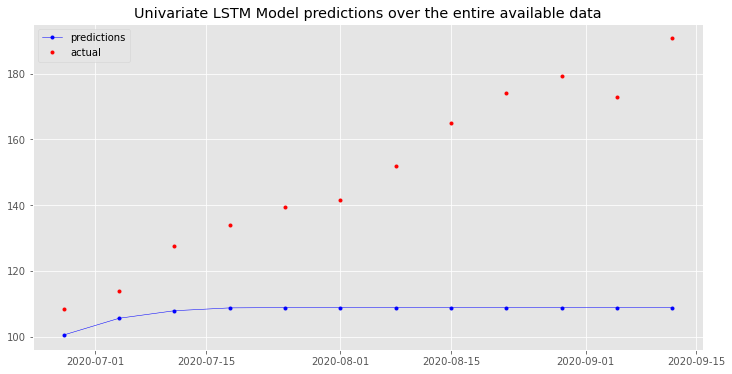

In [471]:
# Plot the predictions (one step ahead) against the test data
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(pd.to_datetime(time_series[-len(y_pred):]), y_pred, 'b.-', label='predictions', lw=0.5)
ax.plot(pd.to_datetime(time_series[-len(y_pred):]), y_test, 'r.', label='actual')
ax.set_title('Univariate LSTM Model predictions over the entire available data')
fig.savefig('../Images/UnivariateLSTMModelPredictions_testdata_entire_available' + get_timestamp())
ax.legend();

In [464]:
# Calculating MAPE (Mean Absolute Precentage Error)
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [465]:
# Calaculate MAPE
print(f'MAPE for known data (before 2020) = {mape(price_series, y_pred)}')

MAPE for know data (before 2020) = 27.561786791817173


In [425]:
LSTM_price_model_history.history

{'loss': [6884.052298948937,
  5752.331497664304,
  5303.083229300902,
  4975.396159693138,
  4677.304922831428,
  4398.913866180735,
  4137.357230589562,
  3890.0181884765625,
  3656.1399391410278,
  3434.158676304768,
  3224.0878188929605,
  3024.549819788982,
  2835.489300600032,
  2656.2333808191042,
  2486.4998307375563,
  2325.329321792445,
  2173.3756606898355,
  2029.2019791750563,
  1893.0825654649243,
  1764.9175276608812,
  1643.492553081709,
  1529.5142243375483,
  1421.842573342864,
  1321.3729556368799,
  1226.1052069909795,
  1137.4734201332958,
  1054.1256949827844,
  976.285382143001,
  903.6366618048285,
  835.7495202133337,
  772.7219265023458,
  714.0732008157318,
  659.2565540431701,
  609.0291002411203,
  562.3187796995812,
  519.1297798550006,
  479.30195004178074,
  442.8937164778562,
  409.3424659807657,
  378.4649802139125,
  350.6427420390021,
  324.96064372898377,
  301.60131387612256,
  280.41671678208814,
  261.19764929702603,
  243.9578730003121,
  228.10

In [426]:
def plot_train_history(history, title):
    loss = history.history['loss']
#     val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure(figsize=(20,10))

    plt.plot(epochs, loss, 'b', label='Training loss')
#     plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()


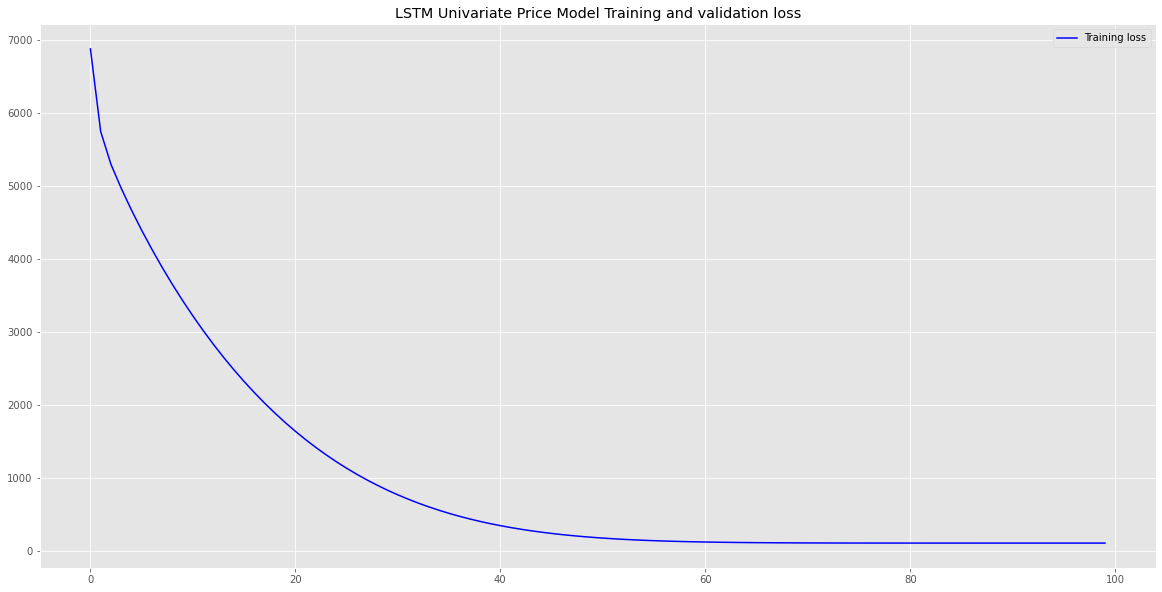

In [427]:
plot_train_history(LSTM_price_model_history, 'LSTM Univariate Price Model Training and validation loss')

In [330]:
# multi-step encoder-decoder lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [331]:
# define dataset
X = array([[10, 20, 30], [20, 30, 40], [30, 40, 50], [40, 50, 60]])
y = array([[40,50],[50,60],[60,70],[70,80]])

In [332]:
X, y

(array([[10, 20, 30],
        [20, 30, 40],
        [30, 40, 50],
        [40, 50, 60]]),
 array([[40, 50],
        [50, 60],
        [60, 70],
        [70, 80]]))

In [333]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))
y = y.reshape((y.shape[0], y.shape[1], 1))

In [334]:
X, y

(array([[[10],
         [20],
         [30]],
 
        [[20],
         [30],
         [40]],
 
        [[30],
         [40],
         [50]],
 
        [[40],
         [50],
         [60]]]),
 array([[[40],
         [50]],
 
        [[50],
         [60]],
 
        [[60],
         [70]],
 
        [[70],
         [80]]]))

In [335]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(3, 1)))
model.add(RepeatVector(2))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=100, verbose=0)
# demonstrate prediction
x_input = array([50, 60, 70])
x_input = x_input.reshape((1, 3, 1))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[[80.883675]
  [95.433334]]]
